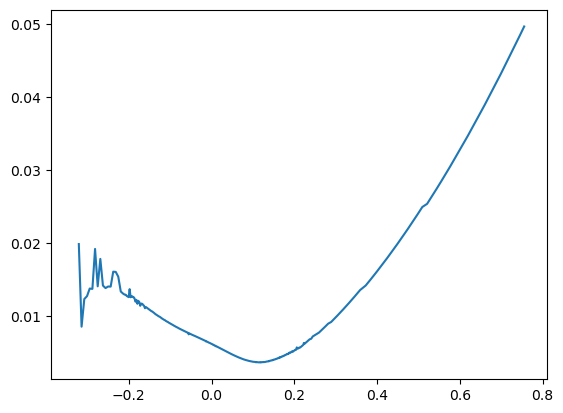

In [3]:
from OptionPricer import BlackScholes
import pandas as pd
import matplotlib.pyplot as plt
call_df = pd.read_csv('../data/cleaned_data/Bloomberg/spx_call_051625_1634.csv')
bs = BlackScholes(call_df)
call_df['my_iv_mid'] = bs.find_imvol_call('mid')
call_df['w'] = call_df['my_iv_mid'] ** 2 * call_df['T']
plt.plot(call_df['x'], call_df['w'])
plt.show()
# df['my_iv_mid'] = BlackScholes

# Global optimization

In [133]:
import numpy as np
from scipy.optimize import differential_evolution, NonlinearConstraint
import matplotlib.pyplot as plt

class SVI:
    def __init__(self, k, w_market, t, init_guess=None):
        self.k = k
        self.w_market = w_market
        self.t = t
        self.bounds = [
            (1e-5, np.max(w_market)),       # a
            (1e-3, 1),                      # b
            (-1 + 1e-6, 1 - 1e-6),          # rho
            (2 * np.min(k), 2 * np.max(k)), # m
            (1e-2, 1)                       # sigma
        ]
        self.result = None
        if init_guess is None:
            self.init_guess = (0.5*(self.w_market.min()), 0.1, -0.5, 0.1, 0.1)
        else:
            self.init_guess = init_guess
        self.a, self.b, self.rho, self.m, self.sigma = self.init_guess

    def objective(self, params):
        a, b, rho, m, sigma = params
        w_model = a + b * (rho * (self.k - m) + np.sqrt((self.k - m)**2 + sigma**2))
        return np.sum((w_model - self.w_market)**2)

    def butterfly_constraints(self, params):
        a, b, rho, m, sigma = params
        epsilon = 1e-8
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

    def fit(self):
        constraint = NonlinearConstraint(lambda x: self.butterfly_constraints(x), lb=0, ub=np.inf)

        result = differential_evolution(self.objective,
                                        bounds=self.bounds,
                                        constraints=(), #(constraint,)
                                        polish=True,
                                        seed=42)
        if result.success:
            self.result = result
            self.a, self.b, self.rho, self.m, self.sigma = result.x
        else:
            print("Optimization failed:", result.message)

    def svi_w(self, k):
        return self.a + self.b * (self.rho * (k - self.m) + np.sqrt((k - self.m)**2 + self.sigma**2))

    @property
    def svi_curve(self):
        return {
            "k": self.k,
            "svi_w": [self.svi_w(k_) for k_ in self.k]
        }

    @property
    def fit_result(self):
        return self.result

    @property
    def params(self):
        return {
            "a": self.a, "b": self.b, "rho": self.rho, "m": self.m, "sigma": self.sigma
        }

    def jw_paramas(self):
        nu = (self.a + self.b * (-self.rho * self.m + np.sqrt(self.m ** 2 + self.sigma ** 2))) / self.t
        psi = (1 / np.sqrt(nu * self.t)) * (self.b / 2) * (-self.m / (np.sqrt(self.m**2 + self.sigma**2)) + self.rho)
        p = (1 / np.sqrt(nu * self.t)) * self.b * (1 - self.rho)
        c = (1 / np.sqrt(nu * self.t)) * self.b * (1 + self.rho)
        nu_tilde = (1 / self.t) * (self.a + self.b * self.sigma * np.sqrt(1 - self.rho ** 2))
        return {
            "nu": nu, "psi": psi, "p": p, "c": c, "nu_tilde": nu_tilde
        }

{'a': 0.0017539819287871526, 'b': 0.03466706721288401, 'rho': 0.0005587807620570421, 'm': 0.11562589778761881, 'sigma': 0.05354369282395362}


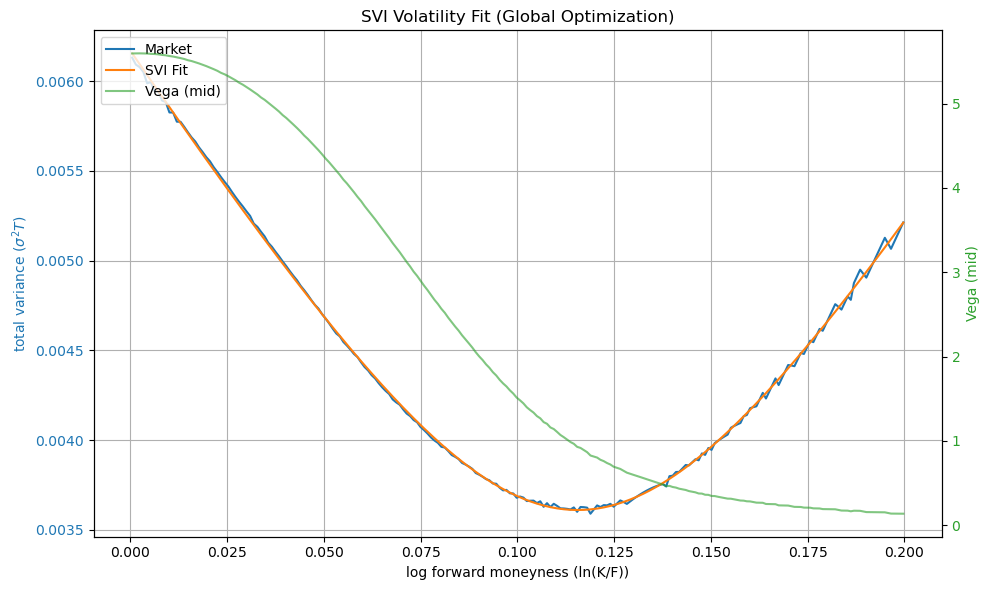

In [134]:
df = call_df[ (call_df['x'] > 0) & (call_df['x'] < 0.2)].loc[:, ["x", "w", "vega_mid"]].dropna()
k = df['x'].values
w = df['w'].values
t = call_df['T'].unique()[0]

svi = SVI(k, w, t)
svi.fit()

print(svi.params)
svi_w = svi.svi_curve['svi_w']
fig, ax = plt.subplots(figsize=(10, 6)) 
ax2 = ax.twinx() 

ax.plot(k, w, label="Market", color='tab:blue')
ax.plot(k, svi_w, label="SVI Fit", color='tab:orange')
ax.set_ylabel(r'total variance ($\sigma^{2}T$)', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2.plot(k, df['vega_mid'].values, label='Vega (mid)', color='tab:green', alpha=0.6)
ax2.set_ylabel('Vega (mid)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax.set_title("SVI Volatility Fit (Global Optimization)")
ax.set_xlabel('log forward moneyness (ln(K/F))')
ax.grid(True)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('SVI_with_dual_axis_vega.png')
plt.show()

In [135]:
def butterfly_constraints(params):
        a, b, rho, m, sigma = params
        epsilon = 1e-8
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

butterfly_constraints(list(svi.params.values()))

[-0.01023492622625491,
 0.021806959310558684,
 3.998796840983969,
 3.9987995271672516]

{'a': 0.0031500422357120944, 'b': 0.007668176126910231, 'rho': 0.9998104706255069, 'm': 0.2015440740538123, 'sigma': 0.1662444450860427}


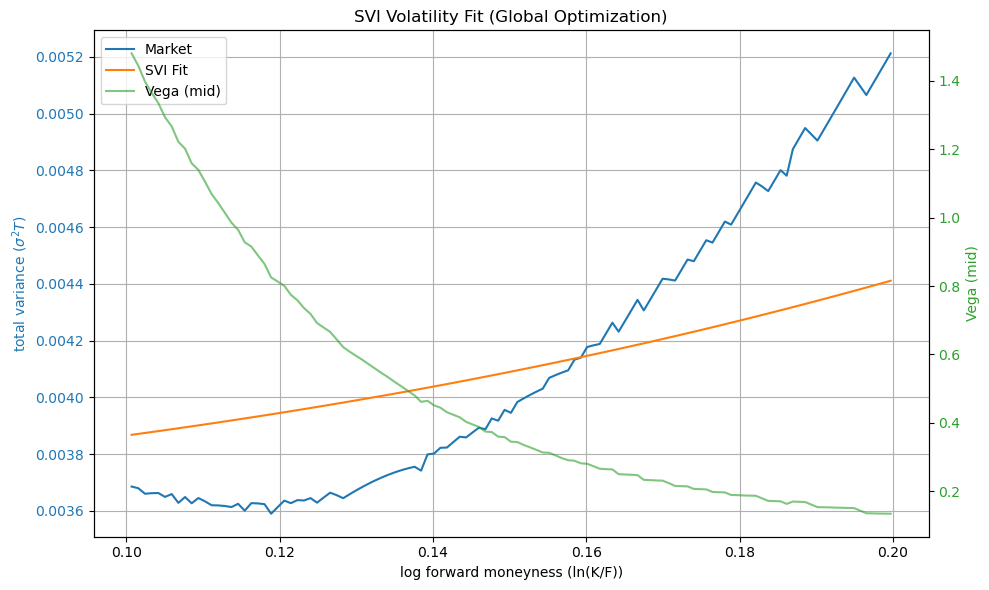

[2.3642863552442057e-06,
 0.012591405981173752,
 3.9997648308754448,
 3.999999989997888]

In [136]:
import numpy as np
from scipy.optimize import differential_evolution, NonlinearConstraint
import matplotlib.pyplot as plt

class SVI:
    def __init__(self, k, w_market, t, init_guess=None):
        self.k = k
        self.w_market = w_market
        self.t = t
        self.bounds = [
            (1e-5, np.max(w_market)),       # a
            (1e-3, 1),                      # b
            (-1 + 1e-6, 1 - 1e-6),          # rho
            (2 * np.min(k), 2 * np.max(k)), # m
            (1e-2, 1)                       # sigma
        ]
        self.result = None
        if init_guess is None:
            self.init_guess = (0.5*(self.w_market.min()), 0.1, -0.5, 0.1, 0.1)
        else:
            self.init_guess = init_guess
        self.a, self.b, self.rho, self.m, self.sigma = self.init_guess

    def objective(self, params):
        a, b, rho, m, sigma = params
        w_model = a + b * (rho * (self.k - m) + np.sqrt((self.k - m)**2 + sigma**2))
        return np.sum((w_model - self.w_market)**2)

    def butterfly_constraints(self, params):
        a, b, rho, m, sigma = params
        epsilon = 1e-8
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

    def fit(self):
        constraint = NonlinearConstraint(lambda x: self.butterfly_constraints(x), lb=0, ub=np.inf)

        result = differential_evolution(self.objective,
                                        bounds=self.bounds,
                                        constraints=(constraint,), #
                                        polish=True,
                                        seed=42)

        if result.success:
            self.result = result
            self.a, self.b, self.rho, self.m, self.sigma = result.x
        else:
            print("Optimization failed:", result.message)

    def svi_w(self, k):
        return self.a + self.b * (self.rho * (k - self.m) + np.sqrt((k - self.m)**2 + self.sigma**2))

    @property
    def svi_curve(self):
        return {
            "k": self.k,
            "svi_w": [self.svi_w(k_) for k_ in self.k]
        }

    @property
    def fit_result(self):
        return self.result

    @property
    def params(self):
        return {
            "a": self.a, "b": self.b, "rho": self.rho, "m": self.m, "sigma": self.sigma
        }

    def jw_paramas(self):
        nu = (self.a + self.b * (-self.rho * self.m + np.sqrt(self.m ** 2 + self.sigma ** 2))) / self.t
        psi = (1 / np.sqrt(nu * self.t)) * (self.b / 2) * (-self.m / (np.sqrt(self.m**2 + self.sigma**2)) + self.rho)
        p = (1 / np.sqrt(nu * self.t)) * self.b * (1 - self.rho)
        c = (1 / np.sqrt(nu * self.t)) * self.b * (1 + self.rho)
        nu_tilde = (1 / self.t) * (self.a + self.b * self.sigma * np.sqrt(1 - self.rho ** 2))
        return {
            "nu": nu, "psi": psi, "p": p, "c": c, "nu_tilde": nu_tilde
        }
    
df = call_df[ (call_df['x'] > 0.1) & (call_df['x'] < 0.2)].loc[:, ["x", "w", "vega_mid"]].dropna()
k = df['x'].values
w = df['w'].values
t = call_df['T'].unique()[0]

svi = SVI(k, w, t)
svi.fit()

print(svi.params)
svi_w = svi.svi_curve['svi_w']
fig, ax = plt.subplots(figsize=(10, 6)) 
ax2 = ax.twinx() 

ax.plot(k, w, label="Market", color='tab:blue')
ax.plot(k, svi_w, label="SVI Fit", color='tab:orange')
ax.set_ylabel(r'total variance ($\sigma^{2}T$)', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2.plot(k, df['vega_mid'].values, label='Vega (mid)', color='tab:green', alpha=0.6)
ax2.set_ylabel('Vega (mid)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax.set_title("SVI Volatility Fit (Global Optimization)")
ax.set_xlabel('log forward moneyness (ln(K/F))')
ax.grid(True)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('SVI_with_dual_axis_vega.png')
plt.show()

def butterfly_constraints(params):
        a, b, rho, m, sigma = params
        epsilon = 1e-8
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

butterfly_constraints(list(svi.params.values()))

In [137]:
df.to_csv('data.csv')

In [138]:
print("# datapoints for which k < 0.1:", len(df[df['x'] < 0.1]))
print("# datapoints for which k > 0.1:", len(df[df['x'] > 0.1]))

# datapoints for which k < 0.1: 0
# datapoints for which k > 0.1: 113


It is highly likely that the curve was poorly fitted due to the imbalance in the number of data points.

In [139]:
jw_params = svi.jw_paramas()
for key, value in jw_params.items():
    print(f"{key}: {value:.4f}")

print("right wing slope (linear):", (max(w) - min(w))/(max(k) - min(k)))

nu: 0.0533
psi: 0.0146
p: 0.0000
c: 0.2553
nu_tilde: 0.0469
right wing slope (linear): 0.01638688878730227


             message: Optimization terminated successfully.
             success: True
                 fun: 2.149968959911558e-05
                   x: [ 2.743e-02  1.682e-01 -1.447e-01  4.301e-02
                        1.851e-01]
                 nit: 147
                nfev: 13772
          population: [[ 3.253e-02  1.480e-01 ...  6.279e-02  1.743e-01]
                       [ 3.738e-02  1.322e-01 ...  7.519e-02  1.580e-01]
                       ...
                       [ 3.742e-02  1.319e-01 ...  7.570e-02  1.577e-01]
                       [ 3.439e-02  1.416e-01 ...  6.755e-02  1.686e-01]]
 population_energies: [ 2.150e-05  2.191e-05 ...  2.221e-05  2.180e-05]
              constr: [array([ 0.000e+00,  0.000e+00,  0.000e+00,
                              0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0
                 jac: [array([[ 3.958e+00, -3.917e-01, ..., -5.694e-01,
                               0.000e+00],
                             [ 3.929e+00, -2.

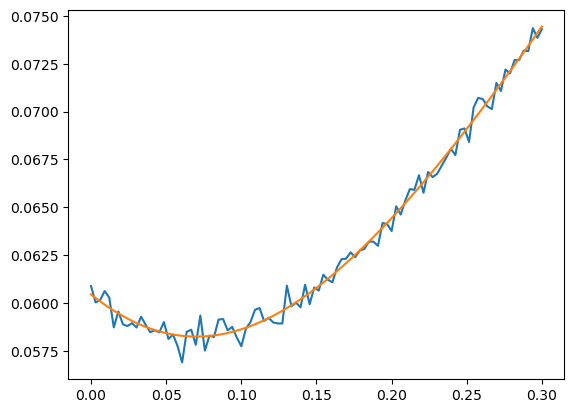

In [140]:
k = np.linspace(0, 0.3, 100)
true_params = (0.02, 0.2, -0.3, 0.0, 0.2)
a, b, rho, m, sigma = true_params
w_market = a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Add small noise
np.random.seed(0)
w_market += np.random.normal(0, 0.0005, size=w_market.shape)

# Time to maturity
T = 0.5

# Fit using SVI class
svi = SVI(k, w_market, T)
svi.fit()

print(svi.fit_result)
svi_w = svi.svi_curve['svi_w']
plt.plot(k, w_market)
plt.plot(k, svi_w)
plt.show()

0.018598071391499313

# Weighting

{'a': 0.003214066196120924, 'b': 0.028974240582070574, 'rho': 0.012683277643222832, 'm': 0.10213350583687919, 'sigma': 0.010440212990775969}


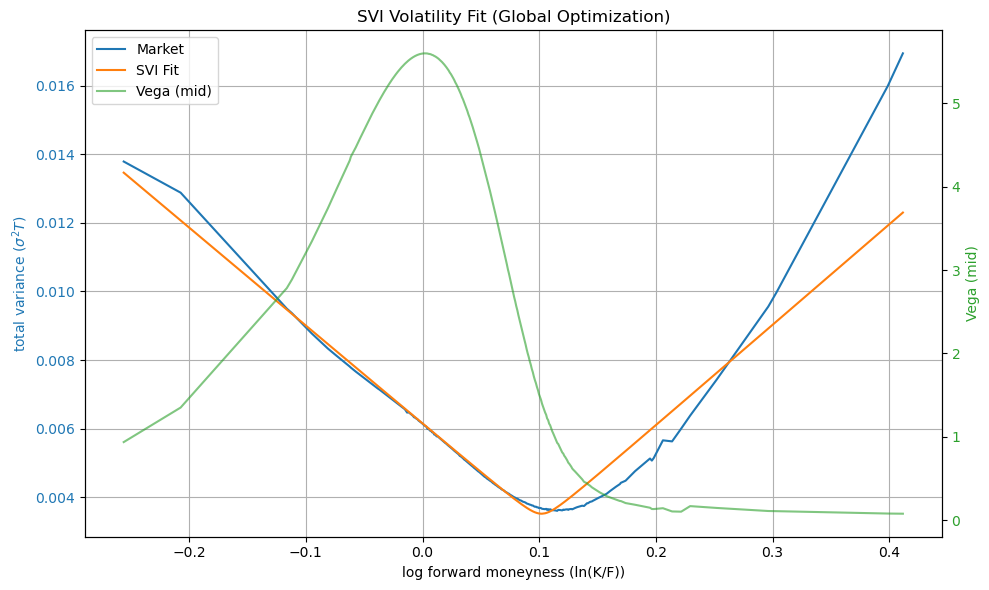

{'a': 0.00020210264452153763, 'b': 0.046840719429851095, 'rho': 0.2739608386709882, 'm': 0.14617337383376686, 'sigma': 0.07599142162762346}


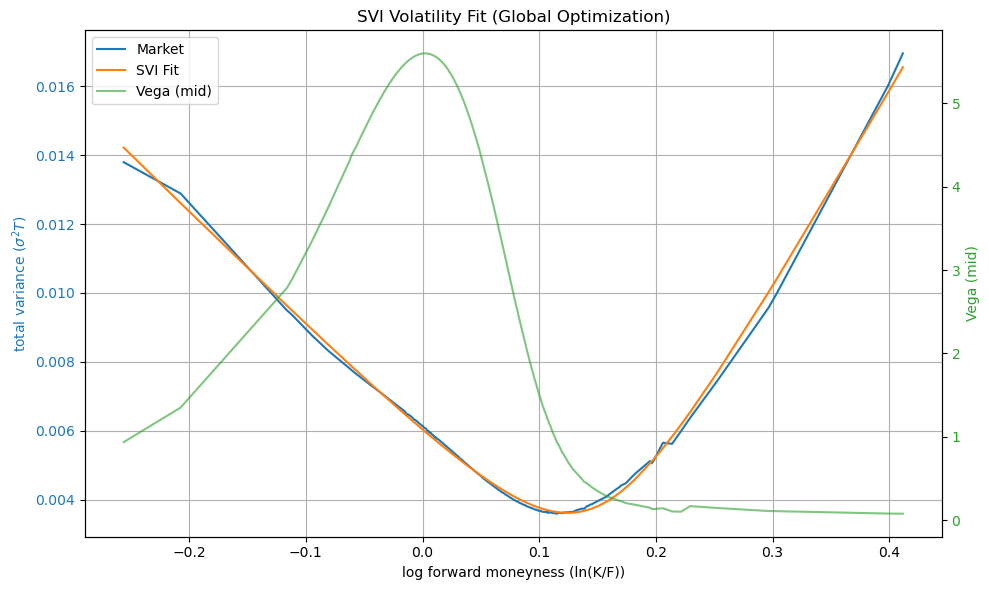

[-0.037715651364859486,
 0.019509452556948616,
 3.9964390941642893,
 3.998843432560554]

In [6]:
import numpy as np
from scipy.optimize import differential_evolution, NonlinearConstraint
import matplotlib.pyplot as plt

class SVI:
    def __init__(self, k, w_market, t, weight, init_guess=None):
        self.k = k
        self.w_market = w_market
        self.t = t
        self.bounds = [
            (1e-5, np.max(w_market)),       # a
            (1e-3, 1),                      # b
            (-1 + 1e-6, 1 - 1e-6),          # rho
            (2 * np.min(k), 2 * np.max(k)), # m
            (1e-2, 1)                       # sigma
        ]
        self.result = None
        if init_guess is None:
            self.init_guess = (0.5*(self.w_market.min()), 0.1, -0.5, 0.1, 0.1)
        else:
            self.init_guess = init_guess
        self.a, self.b, self.rho, self.m, self.sigma = self.init_guess
        self.weight = weight

    def objective(self, params):
        a, b, rho, m, sigma = params
        w_model = a + b * (rho * (self.k - m) + np.sqrt((self.k - m)**2 + sigma**2))
        return np.sum((w_model - self.w_market)**2)

    def butterfly_constraints(self, params):
        a, b, rho, m, sigma = params
        epsilon = 1e-8
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

    def fit(self, constrained = True, bounded = True):
        constraint = NonlinearConstraint(lambda x: self.butterfly_constraints(x), lb=0, ub=np.inf)
        if constrained and bounded:
            result = differential_evolution(self.objective,
                                            bounds=self.bounds,
                                            constraints=(constraint,), #
                                            polish=True,
                                            seed=42)
        if constrained and not bounded:
            result = differential_evolution(self.objective,
                                            bounds=[(0, 10), (0, 1.1), (-1, 1), (-10, 10), (0, 3)],
                                            constraints=(constraint,), #
                                            polish=True,
                                            seed=42)
        if not constrained and bounded:
            result = differential_evolution(self.objective,
                                            bounds=self.bounds,
                                            constraints=(), #
                                            polish=True,
                                            seed=42)
        if not constrained and not bounded:
            result = differential_evolution(self.objective,
                                            bounds=[(0, 10), (0, 1.1), (-1, 1), (-10, 10), (0, 3)],
                                            constraints=(), #
                                            polish=True,
                                            seed=42)
            
        if result.success:
            self.result = result
            self.a, self.b, self.rho, self.m, self.sigma = result.x
        else:
            print("Optimization failed:", result.message)

    def svi_w(self, k):
        return self.a + self.b * (self.rho * (k - self.m) + np.sqrt((k - self.m)**2 + self.sigma**2))

    @property
    def svi_curve(self):
        return {
            "k": self.k,
            "svi_w": [self.svi_w(k_) for k_ in self.k]
        }

    @property
    def fit_result(self):
        return self.result

    @property
    def params(self):
        return {
            "a": self.a, "b": self.b, "rho": self.rho, "m": self.m, "sigma": self.sigma
        }

    def jw_paramas(self):
        nu = (self.a + self.b * (-self.rho * self.m + np.sqrt(self.m ** 2 + self.sigma ** 2))) / self.t
        psi = (1 / np.sqrt(nu * self.t)) * (self.b / 2) * (-self.m / (np.sqrt(self.m**2 + self.sigma**2)) + self.rho)
        p = (1 / np.sqrt(nu * self.t)) * self.b * (1 - self.rho)
        c = (1 / np.sqrt(nu * self.t)) * self.b * (1 + self.rho)
        nu_tilde = (1 / self.t) * (self.a + self.b * self.sigma * np.sqrt(1 - self.rho ** 2))
        return {
            "nu": nu, "psi": psi, "p": p, "c": c, "nu_tilde": nu_tilde
        }

call_df = pd.read_csv('../data/cleaned_data/Bloomberg/spx_call_051625_1634.csv')
call_df['my_iv_mid'] = bs.find_imvol_call('mid')
call_df['w'] = call_df['my_iv_mid'] ** 2 * call_df['T']
df = call_df.loc[:, ["x", "w", "volume", "vega_mid"]].dropna() # [ (call_df['x'] > 0.1) & (call_df['x'] < 0.2)]
k = df['x'].values
w = df['w'].values
t = call_df['T'].unique()[0]
weight = df['volume'].values

svi = SVI(k, w, weight, t)
svi.fit()

print(svi.params)
svi_w = svi.svi_curve['svi_w']
fig, ax = plt.subplots(figsize=(10, 6)) 
ax2 = ax.twinx() 

ax.plot(k, w, label="Market", color='tab:blue')
ax.plot(k, svi_w, label="SVI Fit", color='tab:orange')
ax.set_ylabel(r'total variance ($\sigma^{2}T$)', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2.plot(k, df['vega_mid'].values, label='Vega (mid)', color='tab:green', alpha=0.6)
ax2.set_ylabel('Vega (mid)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax.set_title("SVI Volatility Fit (Global Optimization)")
ax.set_xlabel('log forward moneyness (ln(K/F))')
ax.grid(True)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('SVI_with_dual_axis_vega.png')
plt.show()

svi = SVI(k, w, weight, t)
svi.fit(constrained=False, bounded=False)

print(svi.params)
svi_w = svi.svi_curve['svi_w']
fig, ax = plt.subplots(figsize=(10, 6)) 
ax2 = ax.twinx() 

ax.plot(k, w, label="Market", color='tab:blue')
ax.plot(k, svi_w, label="SVI Fit", color='tab:orange')
ax.set_ylabel(r'total variance ($\sigma^{2}T$)', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2.plot(k, df['vega_mid'].values, label='Vega (mid)', color='tab:green', alpha=0.6)
ax2.set_ylabel('Vega (mid)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

ax.set_title("SVI Volatility Fit (Global Optimization)")
ax.set_xlabel('log forward moneyness (ln(K/F))')
ax.grid(True)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('SVI_with_dual_axis_vega.png')
plt.show()

def butterfly_constraints(params):
        a, b, rho, m, sigma = params
        epsilon = 1e-8
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

butterfly_constraints(list(svi.params.values()))

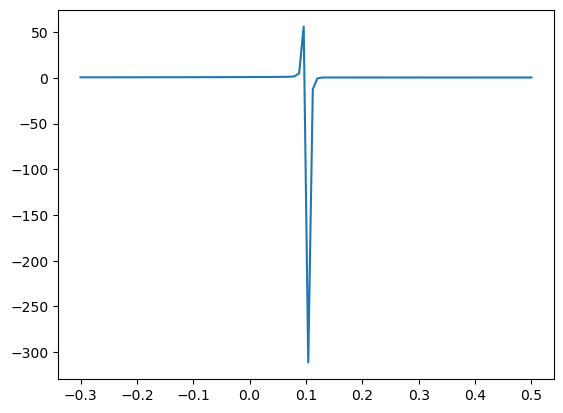

In [11]:
def g(k, params):
    a, b, rho, m, sigma = params
    w = a + b * (rho*(k-m) + np.sqrt((k-m)**2 + sigma**2))
    dw = b * (rho + (k-m)/np.sqrt((k-m)**2 + sigma**2))
    d2w = b * sigma**2 / ((k-m)**2 + sigma**2) ** (3/2)
    g = (1-(k*dw)/(2*w)) - (d2w**2/4)*(1/dw + 1/4) + d2w/2
    return g

p_set = {'a': 0.003214066196120924, 'b': 0.028974240582070574, 'rho': 0.012683277643222832, 'm': 0.10213350583687919, 'sigma': 0.010440212990775969}

params = list(p_set.values())
k_grid = np.linspace(-0.3, 0.5, 100)
gk = []
for k in k_grid:
    gk.append(g(k, params))
    
plt.plot(k_grid, gk)

In [125]:
from scipy.stats import norm
import numpy as np


def RND(svi_params, df):
    a, b, rho, m, sigma = svi_params
    strikes = df['K'].values
    S = np.unique(df['S'])[0]
    r = np.unique(df['r'])[0]
    q = np.unique(df['q'])[0]
    t = np.unique(df['T'])[0]
    F = S * np.exp((r - q) * t)

    # Dense grid
    strike_min = int(np.floor(np.nanmin(strikes)))
    strike_max = int(np.ceil(np.nanmax(strikes)))
    strike_grid = np.arange(strike_min, strike_max + 1, 1)
    k_grid = np.array([np.log(strike / F) for strike in strike_grid])
    
    # SVI total variance → implied vol
    svi_w_grid = a + b * (rho * (k_grid - m) + np.sqrt((k_grid - m)**2 + sigma**2))
    iv_grid = np.sqrt(svi_w_grid / t)

    # Black-Scholes prices
    d1 = (np.log(F / strike_grid) + 0.5 * iv_grid**2 * t) / (iv_grid * np.sqrt(t))
    d2 = d1 - iv_grid * np.sqrt(t)
    bs_call_grid = F * norm.cdf(d1) - strike_grid * norm.cdf(d2)

    # Central difference for RND
    dK = strike_grid[1] - strike_grid[0]
    print("dK:", dK)
    d2C = np.gradient(np.gradient(bs_call_grid, dK), dK)
    rnd = np.exp(-r * t) * d2C

    return strike_grid, rnd

params = list(svi.params.values())
call_df = pd.read_csv('../data/cleaned_data/Bloomberg/spx_call_051625_1634.csv')
rnd = RND(params, call_df)

dK: 1


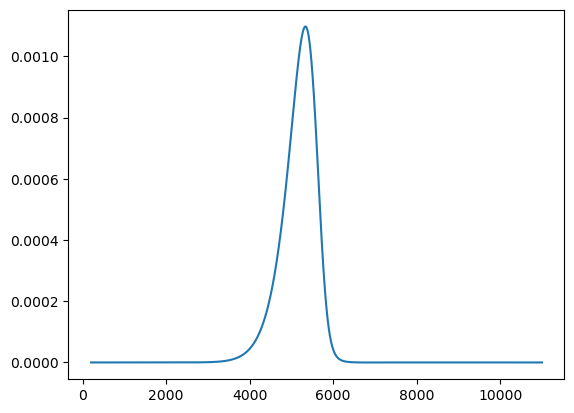

In [126]:
plt.plot(rnd[0], rnd[1])

In [127]:
sum(rnd[1])

0.9969145490023106

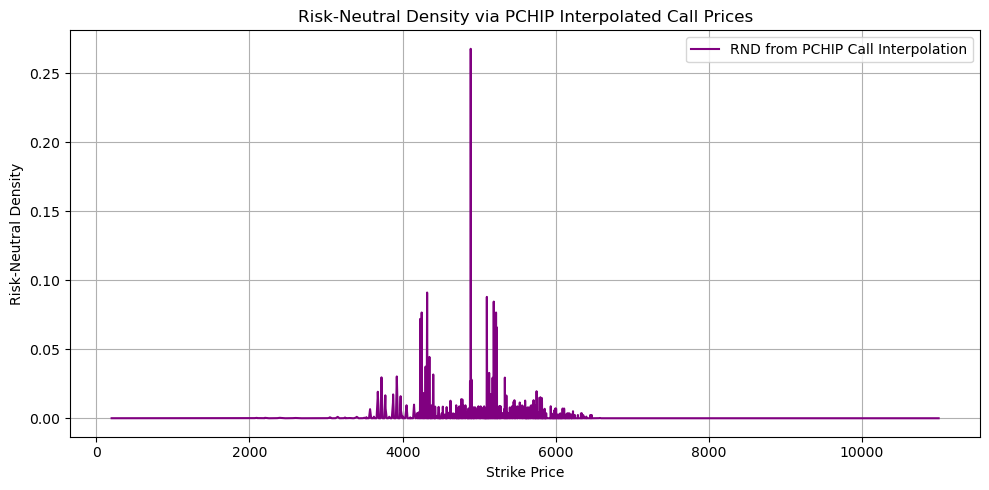

In [128]:
# direct interpolation
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from numpy import exp, gradient

def RND_from_PCHIP(df):
    # 필수 열: K (strike), C (call price), r, T
    K = df['K'].values
    C = df['mid'].values
    r = np.unique(df['r'])[0]
    q = np.unique(df['q'])[0]
    t = np.unique(df['T'])[0]

    # 1단위로 보간할 strike grid
    K_grid = np.arange(np.floor(np.min(K)), np.ceil(np.max(K)) + 1, 1)

    # PCHIP 보간
    pchip = PchipInterpolator(K, C)
    C_interp = pchip(K_grid)

    # 2차 미분 (중앙차분)
    dK = K_grid[1] - K_grid[0]
    d2C = np.zeros_like(C_interp)
    d2C[1:-1] = (C_interp[:-2] - 2 * C_interp[1:-1] + C_interp[2:]) / dK**2
    d2C[0] = d2C[1]
    d2C[-1] = d2C[-2]

    # RND 계산
    rnd = exp(-r * T) * d2C
    rnd[rnd < 0] = 0  # 음수 제거 (수치 오류)

    return K_grid, rnd

strike_grid, rnd = RND_from_PCHIP(call_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(strike_grid, rnd, label='RND from PCHIP Call Interpolation', color='purple')
plt.xlabel("Strike Price")
plt.ylabel("Risk-Neutral Density")
plt.title("Risk-Neutral Density via PCHIP Interpolated Call Prices")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

